# Classification of Skin Cancer

# Summary

In the last few days, hot weather hit several countries in Asia. Indonesia is no exception, even though Indonesia is still relatively safe from other countries in this extreme weather. The Ministry of Health urges the public to use sunscreen with a minimum SPF of 30 to avoid the possibility of sun exposure which can cause skin cancer. Skin cancer itself is the ultraviolet rays from the sun and not the heat that causes sunburn or skin cancer. therefore creating a skin cancer classification model is very useful at this time. to diagnose skin cancer in a person.

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from skimage.io import imread
from skimage.transform import resize, rescale

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp ./drive/MyDrive ./data

cp: -r not specified; omitting directory './drive/MyDrive'


#### DataFrame

In [4]:
def load_file_paths(path):
    files = list(pathlib.Path(path).glob("**/*.jpg"))
    files = [str(f) for f in files]
    
    res = pd.DataFrame({"File": files})
    res["Label"] = res["File"].apply(lambda x: x.split("/")[-2])
    return res

df_train = load_file_paths("drive/MyDrive/data/train")
df_test = load_file_paths("drive/MyDrive/data/test")

df_train.head()

,File,Label
0,drive/MyDrive/data/train/benign/1650.jpg,benign
1,drive/MyDrive/data/train/benign/1438.jpg,benign
2,drive/MyDrive/data/train/benign/1640.jpg,benign
3,drive/MyDrive/data/train/benign/1705.jpg,benign
4,drive/MyDrive/data/train/benign/1457.jpg,benign


In [5]:
df_test.head()

,File,Label
0,drive/MyDrive/data/test/benign/1.jpg,benign
1,drive/MyDrive/data/test/benign/1018.jpg,benign
2,drive/MyDrive/data/test/benign/1006.jpg,benign
3,drive/MyDrive/data/test/benign/10.jpg,benign
4,drive/MyDrive/data/test/benign/1013.jpg,benign


In [6]:
df_test.shape

(660, 2)

In [7]:
df_train.shape

(2637, 2)

In [8]:
df_train["Label"].value_counts()

benign       1440
malignant    1197
Name: Label, dtype: int64

In [9]:
label_dict = {
    "benign": 0,
    "malignant": 1
}

df_train["Label"] = df_train["Label"].map(label_dict)
df_test["Label"] = df_test["Label"].map(label_dict)

## Visualization

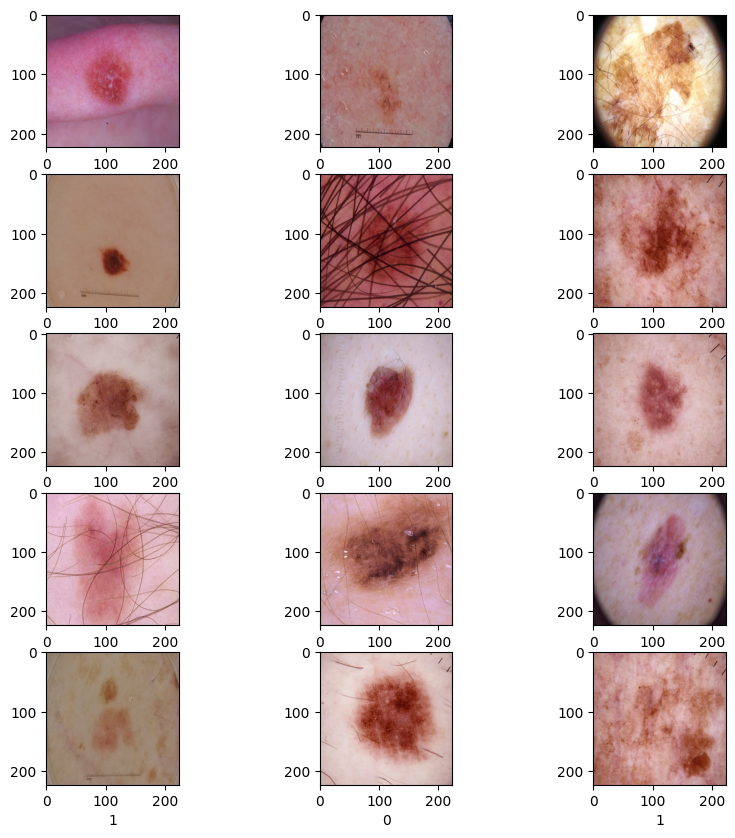

In [10]:
def plot_images(df,path_col,label_col,max_imgs=9):
    df = df.sample(df.shape[0],random_state=3)
    images = df.iloc[:15,:]
    if max_imgs % 3 == 0:
        rows = max_imgs // 3
    else:
        rows = max_imgs // 3 + 1
    plt.figure(figsize=(10,10))
    for i in range(max_imgs):
        plt.subplot(rows,3,i+1)
        img = plt.imread(images[path_col].iloc[i])
        plt.imshow(img)
        plt.xlabel(images[label_col].iloc[i])
    plt.show()

plot_images(df_train,"File","Label",max_imgs=15)

In [11]:
def num_batches(total,batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1


#### Resizing and reshaping image
def resize_rescale(img,img_size):
    img = resize(img,img_size)
    
    ### Rescaling images as min max for every channel
    img[:,:,0] = (img[:,:,0] - np.min(img[:,:,0]))/(np.max(img[:,:,0]) - np.min(img[:,:,0]))
    img[:,:,1] = (img[:,:,1] - np.min(img[:,:,1]))/(np.max(img[:,:,1]) - np.min(img[:,:,1]))
    img[:,:,2] = (img[:,:,2] - np.min(img[:,:,2]))/(np.max(img[:,:,2]) - np.min(img[:,:,2]))
    return img


### The generator Function will generate batches for training the model
def gen_batches(df,path_col,label_col,img_size=(128,128,3),batch_size=64):
    batches = num_batches(df.shape[0],batch_size)
    cats = len(df[label_col].unique())
    ## Shuffling
    df = df.sample(df.shape[0],random_state=3)
    
    while True:
        for b in range(batches):
            if df.shape[0] % batch_size == 0 or b < batches - 1:
                img_batch = np.zeros((batch_size, img_size[0],img_size[1],img_size[2]))
                label_batch = np.zeros((batch_size,cats))
                for i in range(batch_size):
                    img = imread(df[path_col].iloc[b*batch_size + i])
                    img = resize_rescale(img,img_size)
                    img_batch[i,:,:,:] = img
                    l = df[label_col].iloc[b*batch_size + i]
                    label_batch[i,l] = 1
            else:
                img_batch = np.zeros((df.shape[0] % batch_size, img_size[0],img_size[1],img_size[2]))
                label_batch = np.zeros((df.shape[0] % batch_size,cats))
                for i in range(df.shape[0] % batch_size):
                    img = imread(df[path_col].iloc[b*batch_size + i])
                    img = resize_rescale(img,img_size)
                    img_batch[i,:,:,:] = img
                    l = df[label_col].iloc[b*batch_size + i]
                    label_batch[i,l] = 1

            yield img_batch, label_batch

In [12]:
train_gen = gen_batches(df_train,"File","Label",img_size=(128,128,3),batch_size=64)
val_gen = gen_batches(df_test,"File","Label",img_size=(128,128,3),batch_size=64)

## Data Preprocessing

In [13]:
#Import Library Preprocessing

import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input


The dataset is divided into 80% train set and 20% test set.

In [14]:
TRAINING_DIR = "drive/MyDrive/data/train"
VALIDATION_DIR = "drive/MyDrive/data/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 2637 images belonging to 2 classes.


In [15]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

Found 660 images belonging to 2 classes.


In [16]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

9406464/9406464 [==============================] - 0s 0us/step


Using a sequential model.

In [17]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation="relu",
                 padding="same"))
model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))

### Compile the model
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics="accuracy")

### Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

#### Using Callbacks.

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.8):
      print("\nAkurasi telah mencapai >80%!")
      self.model.stop_training = True
callbacks = myCallback()

In [19]:
train_steps = num_batches(len(df_train),64)
test_steps = num_batches(len(df_test),64)
history = model.fit_generator(train_gen,validation_data=val_gen,
                    steps_per_epoch=train_steps,validation_steps=test_steps,
                   epochs=30, callbacks=[callbacks])
                   

<ipython-input-19-8bdbc0674c08>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,validation_data=val_gen,


Epoch 1/30
42/42 [==============================] - 612s 15s/step - loss: 0.7398 - accuracy: 0.5544 - val_loss: 0.6551 - val_accuracy: 0.6652
Epoch 2/30
42/42 [==============================] - 293s 7s/step - loss: 0.6119 - accuracy: 0.6868 - val_loss: 1.4099 - val_accuracy: 0.4545
Epoch 3/30
42/42 [==============================] - 302s 7s/step - loss: 0.5724 - accuracy: 0.7156 - val_loss: 0.6973 - val_accuracy: 0.6848
Epoch 4/30
42/42 [==============================] - 302s 7s/step - loss: 0.4788 - accuracy: 0.7524 - val_loss: 0.6131 - val_accuracy: 0.7394
Epoch 5/30
42/42 [==============================] - 302s 7s/step - loss: 0.4503 - accuracy: 0.7766 - val_loss: 0.4478 - val_accuracy: 0.7818
Epoch 6/30
42/42 [==============================] - 306s 7s/step - loss: 0.4109 - accuracy: 0.7956 - val_loss: 0.4709 - val_accuracy: 0.7742
Epoch 7/30
42/42 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8043
Akurasi telah mencapai >80%!
42/42 [=======================

Sometimes, too many epochs when training can cause Overfitting. So it is necessary to set a specific threshold for one or several metric parameters during training. When the threshold is reached, model training must stop. For this reason, implementing Callbacks to stop training at certain threshold metrics is the solution and you can also apply dropouts here to overcome overfitting

#### Make a plot against the accuracy and loss of the model.

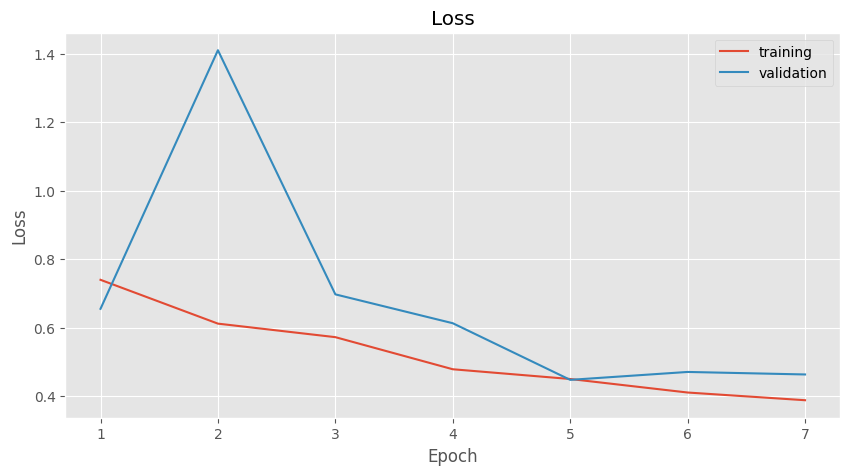

In [20]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['loss'])+1),history.history['loss'], label = 'training')
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label = 'validation')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The output plot also shows the loss or losses generated in each iteration or epoch. At the end of the training process, the loss in the training data reaches 0.3884 while the loss in the validation data reaches 0.4636.

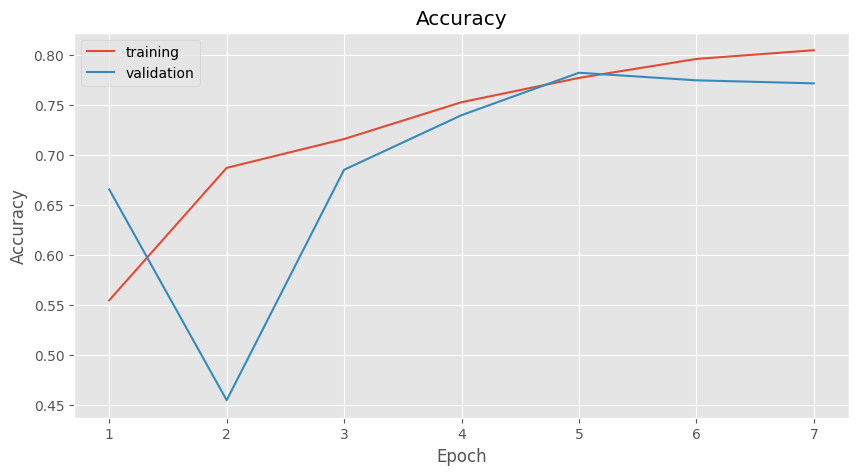

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history["accuracy"], label="training")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label = 'validation')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()



the train and test data have an accuracy of more than 80%, meaning that this number has met the model requirements or is good for classifying skin cancer

#### Change Model

In [22]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

#### Save models into TF-Lite format.

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [24]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


790564

'790564' output shows the size of the model file in bytes after being written to the system file. That is, the size of the vegs.tflite file is 790,564 bytes.
Result of the output is the vegs.tflite file stored on the system with a size of 790,564 bytes. The files can be used to make inferences or predictions on new data using pre-trained TensorFlow Lite models.